## INF2209 COVID-19 Vaccine Twitter Topic Modelling

In [1]:
import numpy as np
import pandas as pd
import html
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import seaborn as sns

import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models


from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

/Users/stephaniezhou/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Load dataset
data obtained from Kaggle: https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
# load the datastet obtained from kaggle
df = pd.read_csv('vaccination_all_tweets.csv')
df.info(verbose=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222403 entries, 0 to 222402
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                222403 non-null  int64 
 1   user_name         222402 non-null  object
 2   user_location     157299 non-null  object
 3   user_description  206192 non-null  object
 4   user_created      222403 non-null  object
 5   user_followers    222403 non-null  int64 
 6   user_friends      222403 non-null  int64 
 7   user_favourites   222403 non-null  int64 
 8   user_verified     222403 non-null  bool  
 9   date              222403 non-null  object
 10  text              222403 non-null  object
 11  hashtags          173757 non-null  object
 12  source            222284 non-null  object
 13  retweets          222403 non-null  int64 
 14  favorites         222403 non-null  int64 
 15  is_retweet        222403 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [4]:
# load the meta data and extract out fields that will be useful to our application
df = df[['user_location','date','text','hashtags']]
df = df.drop_duplicates(subset='text', keep="first")
#df = df.dropna()
df["text"] = df["text"].str.lower()
df.reset_index(inplace=True, drop=True)
df.head()

,user_location,date,text,hashtags
0,"La Crescenta-Montrose, CA",2020-12-20 06:06:44,same folks said daikon paste could treat a cytokine storm #pfizerbiontech https://t.co/xehhimg1kf,['PfizerBioNTech']
1,"San Francisco, CA",2020-12-13 16:27:13,"while the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlchrzjkhm",NaN
2,Your Bed,2020-12-12 20:33:45,#coronavirus #sputnikv #astrazeneca #pfizerbiontech #moderna #covid_19 russian vaccine is created to last 2-4 years… https://t.co/ieylckbr8p,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']"
3,"Vancouver, BC - Canada",2020-12-12 20:23:59,"facts are immutable, senator, even when you're not ethically sturdy enough to acknowledge them. (1) you were born i… https://t.co/jqgv18kch4",NaN
4,NaN,2020-12-12 20:17:19,explain to me again why we need a vaccine @borisjohnson @matthancock #whereareallthesickpeople #pfizerbiontech… https://t.co/kxbsrobehq,"['whereareallthesickpeople', 'PfizerBioNTech']"


In [5]:
df.shape

(220583, 4)

## Data Cleaning:

Twitter tweets contain urls, hashtags (#), mention symbols and potentially html symbols (@) besides punctuations and stop words in other text forms. 
Therefore, text cleaning involves: 
- remove html symbols
- convert html character codes to ASCII
- remove urls
- convert to lowercase
- remove all `STOPWORDS`, can add some custom stop words using nltk
- remove all punctuations including # and @

In [6]:
# convert html character codes to ASCII
df['clean_text'] = df['text'].apply(lambda x: html.unescape(x))

In [7]:
# remove urls
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r"http\S+", "", x))

In [8]:
# remove stop words
stop = stopwords.words('english')
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [9]:
# remove all special characters including #, @, and emojis, only keep keywords after hashtags and mentions
df['clean_text'] = df['clean_text'].str.replace('[^\w\s\...]','')
df['clean_text'] = df['clean_text'].apply(lambda x: x.replace('...',' '))
df['clean_text'] = df['clean_text'].apply(lambda x: x.replace('_',''))

In [10]:
df['clean_text'][3]

'facts immutable senator even ethically sturdy enough acknowledge them. 1 born i'

In [11]:
# convert date to year-month
df['date'] = pd.to_datetime(df['date']).dt.date
df.head()

,user_location,date,text,hashtags,clean_text
0,"La Crescenta-Montrose, CA",2020-12-20,same folks said daikon paste could treat a cytokine storm #pfizerbiontech https://t.co/xehhimg1kf,['PfizerBioNTech'],folks said daikon paste could treat cytokine storm pfizerbiontech
1,"San Francisco, CA",2020-12-13,"while the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlchrzjkhm",NaN,world wrong side history year hopefully biggest vaccination effort weve ev
2,Your Bed,2020-12-12,#coronavirus #sputnikv #astrazeneca #pfizerbiontech #moderna #covid_19 russian vaccine is created to last 2-4 years… https://t.co/ieylckbr8p,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",coronavirus sputnikv astrazeneca pfizerbiontech moderna covid19 russian vaccine created last 24 years
3,"Vancouver, BC - Canada",2020-12-12,"facts are immutable, senator, even when you're not ethically sturdy enough to acknowledge them. (1) you were born i… https://t.co/jqgv18kch4",NaN,facts immutable senator even ethically sturdy enough acknowledge them. 1 born i
4,NaN,2020-12-12,explain to me again why we need a vaccine @borisjohnson @matthancock #whereareallthesickpeople #pfizerbiontech… https://t.co/kxbsrobehq,"['whereareallthesickpeople', 'PfizerBioNTech']",explain need vaccine borisjohnson matthancock whereareallthesickpeople pfizerbiontech


In [12]:
df['clean_text']

0                                             folks said daikon paste could treat cytokine storm pfizerbiontech
1                                    world wrong side history year hopefully biggest vaccination effort weve ev
2         coronavirus sputnikv astrazeneca pfizerbiontech moderna covid19 russian vaccine created last 24 years
3                               facts immutable senator even ethically sturdy enough acknowledge them. 1 born i
4                         explain need vaccine borisjohnson matthancock whereareallthesickpeople pfizerbiontech
                                                          ...                                                  
220578       45 urban bengaluru covidvaccine availability 0411 0930am free slots 0 paid slots covishield  dose1
220579           covid19 sputnik jab proves ineffective resistant russians sputnik sputnikv russiancovidvaccine
220580         1844 bbmp bengaluru covidvaccine availability 0411 0900am free slots covishield  dose1276

## Exploratory Data Analysis

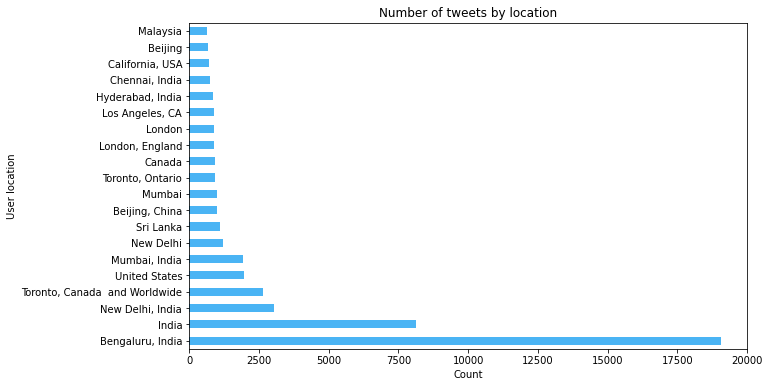

In [13]:
# Visualize tweet count vs location
plt.figure(figsize=(10,6))
df['user_location'].value_counts().nlargest(20).plot(kind='barh', color='#1DA1F2', alpha=0.8)
plt.xlabel('Count')
plt.ylabel('User location')
plt.title('Number of tweets by location')
plt.show()

### Visualization on the vaccine tweets: Word Cloud

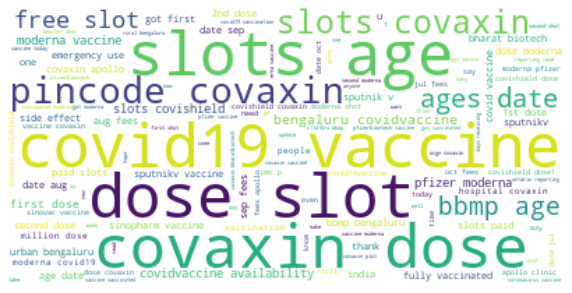

In [14]:
# create a word cloud to visualize the most frequent key words in the vaccine tweets
plt.figure(figsize=(10,8))
text = " ".join(twt for twt in df['clean_text'])
stopwords = set(STOPWORDS)
#stopwords.update(["vaccine"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Topic Model 1: Latent Dirichlet Allocation (LDA)

### Tokenization: Create Bigram and Trigram Models

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df.clean_text.values.tolist()
data_words = list(sent_to_words(data))

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[5]]])

['anyone', 'useful', 'adviceguidance', 'whether', 'covid', 'vaccine', 'safe', 'whilst', 'breastfeeding']


In [17]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['covid', 'slots', 'vaccine','use','ages'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Lemmatize the documents
def lemm(texts):
    return [[WordNetLemmatizer().lemmatize(word, pos='v') for word in doc] for doc in texts]

In [18]:
# remove stop words in addition to the normal english stopwords
data_words = remove_stopwords(data_words)

# form bigrams
data_words = make_bigrams(data_words)

# Lemmatization
data_words = lemm(data_words)
print(data_words[5:][0][:30])

['anyone', 'useful', 'adviceguidance', 'whether', 'safe', 'whilst', 'breastfeed']


In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Filter out words that occur less than 20 documents, or more than 50% of the documents
id2word.filter_extremes(no_below=20, no_above=0.5)

# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[5:][0][:30])

[(32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)]


### Find Optimal Number of Topics for LDA: Coherence vs. Jaccard

In [20]:
from gensim.models import LdaMulticore as LdaModel

In [21]:
# Considering 2-15 topics
num_topics = list(range(16)[2:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=corpus,
                             id2word=id2word,
                             num_topics=i,
                             random_state=97116)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]


In [22]:
# Coherence matrix
coherences = [CoherenceModel(model=LDA_models[i], texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [23]:
# Jaccard similarity function
def jaccard_similarity(topic_1, topic_2):
    """
    Jaccard similarity:
    - Calculate the degree of topic overlap
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [24]:
# derive the mean stability across topics by considering the next topic:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

### Optimal number of topics: where the difference between Coherence and Jaccard Similarity is maximized
code adapted from [stackoverflow](https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin)

In [30]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords-1)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]


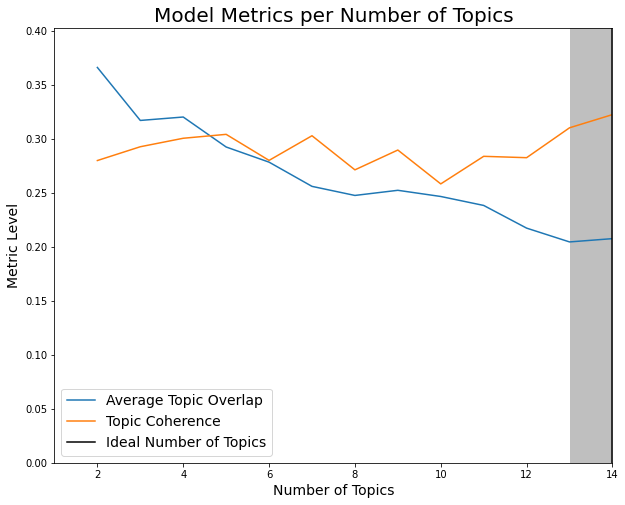

In [83]:
plt.figure(figsize=(10,8))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=20)
ax.set_ylabel('Metric Level', fontsize=14)
ax.set_xlabel('Number of Topics', fontsize=14)
plt.legend(fontsize=14)
plt.show()   

The best LDA model has 13 topics.

In [32]:
# number of topics
num_topics = 13

# Build the best LDA model
best_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      random_state=97116)

In [33]:
pprint(best_model.show_topics(num_topics=13,num_words=20))

[(0,
  '0.063*"sep" + 0.030*"moderna" + 0.024*"jab" + 0.018*"pfizerbiontech" + '
  '0.017*"covaxin" + 0.016*"vaccines" + 0.015*"study" + 0.014*"dose" + '
  '0.014*"first" + 0.014*"pfizer" + 0.012*"get" + 0.010*"second" + 0.009*"do" '
  '+ 0.009*"sputnikv" + 0.008*"effective" + 0.007*"one" + 0.007*"doctorsoumya" '
  '+ 0.007*"new" + 0.007*"shoot" + 0.006*"coronavirus"'),
 (1,
  '0.090*"covaxin" + 0.089*"dose" + 0.043*"covishield" + 0.039*"age" + '
  '0.038*"free" + 0.035*"covidvaccine" + 0.033*"bbmp" + 0.030*"pay" + '
  '0.030*"rs" + 0.027*"pm" + 0.024*"hospital" + 0.021*"bengaluru" + '
  '0.017*"india" + 0.011*"take" + 0.009*"sputnikv" + 0.007*"say" + '
  '0.007*"vaccination" + 0.005*"sputnik" + 0.005*"available" + 0.005*"nd"'),
 (2,
  '0.036*"booster" + 0.032*"get" + 0.023*"moderna" + 0.017*"shoot" + '
  '0.014*"pfizer" + 0.012*"sinopharm" + 0.010*"say" + 0.009*"sputnikv" + '
  '0.009*"pfizerbiontech" + 0.008*"jab" + 0.007*"today" + 0.007*"people" + '
  '0.007*"approve" + 0.007*"vacci

### Interactive report interface

In [46]:
pyLDAvis.enable_notebook()
vis_best = pyLDAvis.gensim_models.prepare(best_model, corpus, id2word)
vis_best

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.218604 -0.037504       1        1  12.930703
1      0.244418 -0.087955       2        1  11.080305
4     -0.028947 -0.152444       3        1   8.918903
10    -0.105562 -0.065403       4        1   8.711825
11    -0.035873  0.090037       5        1   7.800232
7     -0.135295 -0.067513       6        1   7.520229
6      0.074863  0.239079       7        1   7.275851
5     -0.039214  0.031146       8        1   6.448206
9      0.029626 -0.013811       9        1   6.252217
3     -0.063245  0.023388      10        1   6.216231
2     -0.085715  0.017725      11        1   5.924046
8     -0.040421  0.002928      12        1   5.494895
0     -0.033240  0.020326      13        1   5.426355, topic_info=         Term          Freq         Total Category  logprob  loglift
5192  pincode  15745.000000  15745.000000  Default  30.0000  30.0000
2347  covaxin  71311.000000  71311.000000  Default  29.0000  29.0000
509       age  23297.000000  23297.000000  Default  28.0000  28.0000
215      dose  64524.000000  64524.000000  Default  27.0000  27.0000
2169      fee  13079.000000  13079.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
3         say    482.431888   7911.972810  Topic13  -5.2232   0.1166
122      make    386.520198   4732.529393  Topic13  -5.4449   0.4089
14      world    319.709501   3101.175251  Topic13  -5.6346   0.6418
524     india    387.322438   9342.025347  Topic13  -5.4428  -0.2691
339     today    378.692280   9261.318931  Topic13  -5.4653  -0.2830

[1080 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3597      3  0.937138    abudhabi
3597      8  0.037486    abudhabi
5322      4  0.969852  acceptable
2311      1  0.008219     achieve
2311      2  0.217800     achieve
...     ...       ...         ...
2145     12  0.001865       young
2768      7  0.027939     yrs_old
2768      8  0.013970     yrs_old
2768      9  0.097788     yrs_old
2768     13  0.866118     yrs_old

[4443 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 2, 5, 11, 12, 8, 7, 6, 10, 4, 3, 9, 1])

However, it turns out that topic 8, 10, 11, 12, and 13 have lots of overlappings, after re-examining the Coherence and Jaccard Similarity plot, 7 is chosen as another candidate for the optimal topic number. 

In [47]:
# number of topics
num_topics = 7

# Build the best LDA model
best_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      random_state=97116)

In [48]:
pprint(best_model.show_topics(num_topics=7,num_words=20))

[(0,
  '0.039*"fee" + 0.032*"sep" + 0.029*"moderna" + 0.025*"covaxin" + '
  '0.020*"apollo" + 0.020*"dose" + 0.015*"jab" + 0.012*"pfizerbiontech" + '
  '0.012*"first" + 0.012*"vaccines" + 0.011*"get" + 0.010*"pfizer" + '
  '0.010*"second" + 0.008*"new" + 0.008*"study" + 0.007*"sputnikv" + '
  '0.007*"shoot" + 0.007*"one" + 0.006*"take" + 0.006*"case"'),
 (1,
  '0.130*"covaxin" + 0.084*"dose" + 0.060*"age" + 0.030*"date" + 0.028*"bbmp" '
  '+ 0.027*"covishield" + 0.023*"free" + 0.021*"covidvaccine" + 0.020*"rs" + '
  '0.020*"availability" + 0.020*"hospital" + 0.013*"pm" + 0.012*"pay" + '
  '0.010*"india" + 0.010*"bharatbiotech" + 0.009*"aug" + 0.009*"take" + '
  '0.009*"bengaluru" + 0.007*"urban_bengaluru" + 0.005*"vaccination"'),
 (2,
  '0.032*"moderna" + 0.030*"get" + 0.023*"booster" + 0.017*"pfizer" + '
  '0.014*"covaxin" + 0.013*"shoot" + 0.010*"sinopharm" + 0.010*"people" + '
  '0.009*"approve" + 0.009*"approval" + 0.007*"fda" + 0.007*"vaccinate" + '
  '0.006*"say" + 0.006*"sputnik

In [49]:
pyLDAvis.enable_notebook()
vis_best = pyLDAvis.gensim_models.prepare(best_model, corpus, id2word)
vis_best

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.253776 -0.060432       1        1  20.964944
4     -0.081277 -0.125095       2        1  17.595240
6      0.024653  0.200264       3        1  13.685599
2     -0.068645  0.026753       4        1  12.961895
5     -0.015810 -0.009141       5        1  12.474202
3     -0.077914 -0.018513       6        1  12.233854
0     -0.034783 -0.013836       7        1  10.084266, topic_info=             Term          Freq         Total Category  logprob  loglift
5192      pincode  17975.000000  17975.000000  Default  30.0000  30.0000
509           age  21331.000000  21331.000000  Default  29.0000  29.0000
2347      covaxin  69617.000000  69617.000000  Default  28.0000  28.0000
21        moderna  53288.000000  53288.000000  Default  27.0000  27.0000
2169          fee  14485.000000  14485.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
4919          aug    650.895248   3886.589969   Topic7  -5.5434   0.5073
524         india    726.401093   9050.542006   Topic7  -5.4337  -0.2283
2330      sputnik    603.182120   4002.462285   Topic7  -5.6195   0.4017
3             say    625.555521   7628.979980   Topic7  -5.5831  -0.2069
12    vaccination    628.750846   9251.154898   Topic7  -5.5780  -0.3946

[592 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
5322      3  0.985447   acceptable
1386      1  0.089813          add
1386      2  0.048869          add
1386      3  0.132078          add
1386      4  0.060756          add
...     ...       ...          ...
5134      1  0.001835  yearold_man
5134      3  0.002753  yearold_man
5134      5  0.993690  yearold_man
5134      6  0.000918  yearold_man
4689      3  0.995239     yearolds

[1655 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 7, 3, 6, 4, 1])

In [55]:
pyLDAvis.save_html(vis_best, './ldatopics_vis.html')

Considering that Tweets are composed of texts no longer that 280 characters in length, which is quite short in general, I decided to try the BTM topic model. 
<br>Code adepted from [BTM code demo on Github](https://github.com/maximtrp/bitermplus) </br>

## Topic Model 2: Biterm Topic Model for short text

In [85]:
# import BTM module
import bitermplus as btm

### Preprocessing to generate Biterms

In [95]:
# PREPROCESSING
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
texts = df['clean_text'].str.strip().tolist()
X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
tf = np.array(X.sum(axis=0)).ravel()
# Vectorizing documents
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))
# Generating biterms
biterms = btm.get_biterms(docs_vec)


### Optimal number of topics: Perplexity & Coherence

In [69]:
# Considering 2-15 topics
num_topics = list(range(16)[2:])
num_keywords = 20

btm_models = {}
perplexity_list =[]
coherence_list = []
for i in num_topics:
    btm_models[i] = btm.BTM(X, vocabulary, seed=97116, T=i, M=num_keywords)
    btm_models[i].fit(biterms, iterations=20)
    p_zd = btm_models[i].transform(docs_vec)
    perplexity = btm.perplexity(btm_models[i].matrix_topics_words_, p_zd, X, i)
    coherence = btm.coherence(btm_models[i].matrix_topics_words_, X, M=20)
    perplexity_list.append(perplexity)
    coherence_list.append(coherence)

100%|██████████| 220583/220583 [00:01<00:00, 112317.15it/s]


In [70]:
coherence_list

[array([-603.08260547, -659.92540755]),
 array([-759.94614255, -603.09524609, -624.19797436]),
 array([-760.68712528, -664.26513175, -563.84024124, -624.19797436]),
 array([-760.68712528, -701.74788186, -560.35779926, -676.77592362,
        -624.19797436]),
 array([-759.96464002, -643.61649558, -751.76505328, -563.77298169,
        -653.66682301, -624.07608183]),
 array([-759.79758593, -733.58847323, -652.5149779 , -551.29462572,
        -568.51033786, -689.47173446, -624.13465254]),
 array([-759.96464002, -553.04757379, -667.16361325, -682.49131313,
        -572.25044701, -651.74736066, -609.57116809, -624.19797436]),
 array([-759.79758593, -696.10903118, -650.51200552, -676.65777055,
        -675.11084086, -678.5117267 , -684.27997514, -555.05716259,
        -624.13465254]),
 array([-547.90023479, -750.21201738, -679.48568923, -647.18278461,
        -686.95013531, -572.42566375, -550.07700202, -699.24701617,
        -595.29274947, -427.6556441 ]),
 array([-695.77097433, -759.07164893

In [71]:
perplexity_list

[1868.0515458219143,
 1694.8099636933537,
 1463.4782126315135,
 1348.3099899169613,
 1264.6677387565358,
 1213.4064620925517,
 1163.4100938734603,
 1146.5192458403424,
 1046.3489365112657,
 1027.5444789319918,
 982.5379263460895,
 970.6851875537701,
 955.4226466990441,
 909.0541061540978]

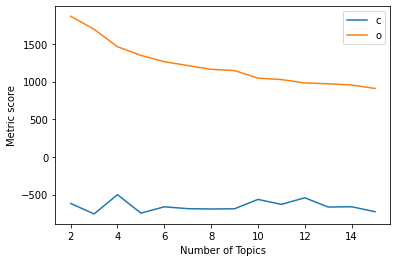

In [72]:
# show graph
limit=16; start=2;
x = range(start, limit)
plt.plot(x, coherence_list[-1][:-1])
plt.plot(x, perplexity_list)
plt.xlabel("Number of Topics")
plt.ylabel("Metric score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Investigate into the negative coherence value:
According to [Bitermplus documentation](https://bitermplus.readthedocs.io/en/latest/benchmarks.html): the coherence metric is calacuted by `u-mass` instead of `c_v` as in the previos LDA model. Therefore the obervation of negative value is normal. 

The best number of topics from BTM would be 12 where the distance between coherence and perplexity is sufficiently small. 

In [97]:
btm_model = btm.BTM(X, vocabulary, seed=12321, T=12, M=20)
btm_model.fit(biterms, iterations=20)
p_zd = btm_model.transform(docs_vec)

100%|██████████| 220583/220583 [00:01<00:00, 123759.01it/s]


In [87]:
import tmplot as tmp

In [99]:
topics_coords = tmp.prepare_coords(btm_model)
topics_coords.head()

,x,y,topic,size,label
0,-1.539635,-185.387695,0,2.135024,0
1,68.198700,-67.290321,1,8.096069,1
2,-113.296486,154.050491,2,11.179950,2
3,197.671753,-22.051462,3,2.356186,3
4,34.328106,177.165497,4,9.145370,4


In [100]:
tmp.plot_scatter_topics(topics_coords, size_col='size', label_col='label')

alt.LayerChart(...)

In [106]:
phi = tmp.get_phi(btm_model)
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=0, lambda_=1)
tmp.plot_terms(terms_probs)

alt.Chart(...)

### The interactive plot not working, TO BE inspected

In [101]:
tmp.report(btm_model, docs=texts, height=400, width=250)